# Machine Learning Assignment 2

- [EDA](#EDA)

## Imports


In [1]:
# Need these
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

#Natural language toolkit. Download if not installed already
import nltk
from nltk import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')

# For splitting by punctuation and using regex
import re
import string

# Useful
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# Potentially used Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC, SVC

# Evaluation and feature selection tools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import chi2, mutual_info_classif

#benchmark
from sklearn.dummy import DummyClassifier

In [2]:
from datetime import datetime

# Files

In [3]:
# read in train and test data

meta_train_df = pd.read_csv("review_meta_train.csv")
text_train_df = pd.read_csv("review_text_train.csv")
train_data = pd.concat([text_train_df, meta_train_df], axis=1)

meta_test_df = pd.read_csv("review_meta_test.csv")
text_test_df = pd.read_csv("review_text_test.csv")
test_data = pd.concat([text_test_df, meta_test_df], axis=1)

In [4]:
train_data.head()

,review,date,review_id,reviewer_id,business_id,vote_funny,vote_cool,vote_useful,rating
0,dear longman & eagle.......you've left me no c...,3/15/2012,-s77HISu8DVQ8F0HxmWW6A,mthr7h15a_z9m9jRI6mG6Q,m5_GCJP2W4zEJnyVgxa3eA,0,1,3,1
1,Delish. The hubby and I wanted to do brunch on...,6/21/2010,A2aCzGCgg6gAbatHiCrPfA,rhM01fl3iU0xHr3TIpCMhQ,m5_GCJP2W4zEJnyVgxa3eA,0,0,0,5
2,"yep, I've giving Yolk 5 stars. It's just reall...",7/29/2011,DK2pd,SNHKDgmGiLn5chUlhdLCkg,CwPi6NVuJIZZx4IBcTekFQ,1,0,1,5
3,"Meat, meat, meat. It's meat-tastic. So much me...",3/10/2006,b3BkUiWJEKNQko,HXjk1RVfLMPeZxitnk1Auw,43rd1LKcZRIunySzbMsyLQ,17,3,3,3
4,I caught up with the law school girls on a Sat...,8/28/2012,RabHhte,W0ny0BqO0OJ4K4aVnSIlBw,CwPi6NVuJIZZx4IBcTekFQ,0,0,0,3


In [5]:
# doc2vec 50, 100, 200 features vector for training
d2v_50_train = pd.read_csv(r"review_text_features_doc2vec50/review_text_train_doc2vec50.csv", index_col = False, delimiter = ",", header=None)
d2v_100_train = pd.read_csv(r"review_text_features_doc2vec100/review_text_train_doc2vec100.csv", index_col = False, delimiter = ",", header=None)
d2v_200_train = pd.read_csv(r"review_text_features_doc2vec200/review_text_train_doc2vec200.csv", index_col = False, delimiter = ",", header=None)

# doc2vec 50, 100, 200 features vector for testing
d2v_50_test = pd.read_csv(r"review_text_features_doc2vec50/review_text_test_doc2vec50.csv", index_col = False, delimiter = ",", header=None)
d2v_100_test = pd.read_csv(r"review_text_features_doc2vec100/review_text_test_doc2vec100.csv", index_col = False, delimiter = ",", header=None)
d2v_200_test = pd.read_csv(r"review_text_features_doc2vec200/review_text_test_doc2vec200.csv", index_col = False, delimiter = ",", header=None)

## EDA

lets take a quick look at the class labels...

In [6]:
print(train_data['rating'].value_counts())

5    19288
3     6444
1     2336
Name: rating, dtype: int64


Looks like 5 stars is by far the most popular class. Potentially could look to undersample class 5 or oversample classes 1 and 3 when training the data. Otherwise, the learner might get lazy and select the majority class too often. As a benchmark, we can look to outperform the ZeroR classifier.

In [7]:
zeroR = DummyClassifier(strategy = "most_frequent")
zeroR.fit(train_data.rating, train_data.rating)
score = zeroR.score(train_data.rating, train_data.rating)
print("zeroR accuracy is {:.4f}...".format(score))

zeroR accuracy is 0.6872...


exploration of the meta data...

In [8]:
rating_value_counts = train_data.groupby(['reviewer_id'])['rating'].count().reset_index().rating.value_counts()
rating_value_counts = rating_value_counts.reset_index().rename(columns = {"index": "count"})
rating_value_counts

,count,rating
0,1,15777
1,2,2596
2,3,805
3,4,364
4,5,208
5,6,103
6,7,74
7,8,37
8,9,24
9,10,11


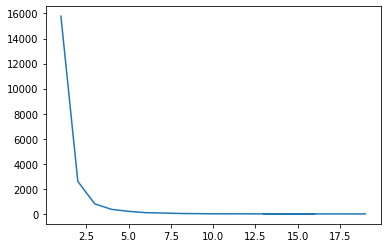

In [9]:
plt.plot(rating_value_counts["count"], rating_value_counts["rating"])

A vast majority of reviewers have either 1 or 2 reviews... However, some reviewers have multiple reviews. This could be a useful feature to detect some edge cases...

In [10]:
# transform the vote counts into percentage votes 

votes = ['vote_funny', 'vote_cool', 'vote_useful']
# votes_df = train_data[['vote_funny', 'vote_cool', 'vote_useful', 'rating']]
train_data['total_votes'] = train_data['vote_funny'] + train_data['vote_cool'] + train_data['vote_useful']

for vote in votes:
    percentage_votes = 'percentage_' + vote
    train_data[percentage_votes] = train_data[vote] / train_data['total_votes']
    
train_data = train_data.fillna(0)

In [11]:
train_data.groupby(['rating']).agg(
    {
        'percentage_vote_funny': ['mean'], 
        'percentage_vote_cool': ['mean'],
        'percentage_vote_useful': ['mean']
    }
)

,percentage_vote_funny,percentage_vote_cool,percentage_vote_useful
,mean,mean,mean
rating,,,
1,0.142341,0.051008,0.289528
3,0.088110,0.088423,0.260617
5,0.075794,0.130812,0.214226


There appears to be directionality between the mean percentage votes and the rating someone is given... Perhaps this could be useful in cases where a machine learning algorithm cannot detect sarcasm by itself. Lets look at some of these funny reviews as an example!

In [12]:
train_data.loc[(train_data.rating == 1) & (train_data.percentage_vote_funny > 0.5)].reset_index().iloc[0].review

"snooze-a-roo. I ordered some breakfast sandwich, and when it showed up, it was just a croissant with two strips of bacon on it and nothing else, so fifteen minutes later when the waitress came back and I complained, she brought me a plate with the other stuff that was supposed to come on it. It cost 12 dollars and the wait is a half hour to be smashed in a corner where there is nowhere to put your winter coat. I can't understand the appeal of this place. I would recommend that folks try anything else for breakfast. Maybe a donkey punch or a dirty sanchez would be more satisfying.\n"

The author is being sarcastic "Maybe a donkey punch or a dirty sanchez would be more satisfying" but you would also expect this review to receive a negative rating...

What about data? are critics getting harsher over time, or is there another trend we are able to detect?

In [13]:
train_data['date'] = pd.to_datetime(train_data['date'])

In [14]:
train_data['year'] = train_data['date'].apply(lambda x: x.year)

In [15]:
train_data.groupby(['year']).agg({'rating': ['mean', 'count']})

rating      
          mean count
year                
2004  5.000000     4
2005  4.580000   100
2006  4.360902   532
2007  4.256887  1561
2008  4.159780  2904
2009  4.197502  4324
2010  4.225112  6499
2011  4.212743  7314
2012  4.174741  4830

Do critics get harsher over time? or perhaps do movies get worse??? or maybe its just due to the small sample size in years 2004 and 2005.

# Preprocessing
consider in countvectoriser: not using stopwords param, adding lemmatizer param

In [16]:
# # Here, choose which predefined and given vector to use to represent the text data.
# # Text here is already processed

# d2vtrain = [d2v_50_train, d2v_100_train, d2v_200_train]
# d2v_50_train.name = "d2v_50"
# d2v_100_train.name = "d2v_100"
# d2v_200_train.name = "d2v_200"

# # Function to split a doc2Vec vector into training and testing
# def splitDoc2Vec(doc, randomstate = 8579):
#     # For each of the doc2vec vectors, concat with meta features
#     train = doc
#     train = pd.concat([train.reset_index(), train_meta.reset_index()], axis = 1)
    
#     # Above concat method causes duplicating index column
#     train = train.loc[:,~train.columns.duplicated()]
#     train = train.drop(columns = ['index'])
    
#     # Split into training and validation sets
#     X_train, X_test, Y_train, Y_test = train_test_split(train[train.columns[:-1]],
#                                                         train["rating"], test_size=0.20, random_state=randomstate)
#     return X_train, X_test, Y_train, np.array(Y_test)

# # Function to split the given sparse matrix into training and testing
# def splitSparse(randomstate = 8579):
#     X_train, X_vali, Y_train, Y_vali = train_test_split(sparse_matrix_train, 
#                                                             train_data["rating"], test_size=0.20, random_state=randomstate)
#     return X_train, X_vali, Y_train, np.array(Y_vali)

# # Function to split the training data into train and test, but first vectorising the reviews
# def splitVectorised(ngram_range = (1,1), randomstate = 8579):
#     # Split the reviews and ratings
#     X_train, X_vali, Y_train, y_vali = train_test_split(train_data["review"], train_data["rating"], test_size=0.20, random_state=randomstate)
#     X_train_txt, y_train = np.array(X_train), np.array(X_train)
#     X_test_txt, y_test = np.array(X_vali), np.array(y_vali)
        
#     # vectorise the reviews
#     vectoriser = CountVectorizer(ngram_range=ngram_range) #optional stop_words = 'english', tokenizer=LemmaTokenizer()
#     vectoriser.fit(X_train_txt)
#     X_train = vectoriser.transform(X_train_txt)
#     X_test = vectoriser.transform(X_test_txt)
    
#     # Need to return vectoriser fit external test set
#     return X_train, X_test, Y_train, y_test, vectoriser

# Run classifiers using a single train test split to get some crude results. Cross validation comes later

In [17]:
# # Crude accuracy score and confusion matrix of predictions with % correct. Matrix is "Predicted label x for an instance
# # with Class label y"

# def evaluate(truthlist, predictions):
#     # First calculate a crude accuracy score
#     correct = 0;
#     wrong = 0;
#     for i in range(0,len(truthlist)):
#         if(truthlist[i] == predictions[i]):
#             correct += 1
#         else:
#             wrong += 1;
#     print("The accuracy of the predictions is: {:.5f}\n".format(correct/(correct + wrong)))
        
#     # Now construct a confusion matrix of each attribute
#     truthSeries = pd.Series(truthlist, name = "Truths")
#     predictionSeries = pd.Series(predictions, name = "Predictions")
    
#     # Now normalise the confusion matrix so its a percentage of classification performance
#     confusionDf = pd.crosstab(truthSeries, predictionSeries, rownames=["Truths"], colnames=["Predicted"], margins=False)
#     confusionDfNormalised = confusionDf / confusionDf.sum(axis=0)
#     print("Confusion Matrix of Correctly Labeled Classes %'s\n")
#     print(confusionDfNormalised)
#     print("\n\n")
    
#     return

# Lemmatizer if wanted in countvectoriser()

In [18]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
train_data.head()

,review,date,review_id,reviewer_id,business_id,vote_funny,vote_cool,vote_useful,rating,total_votes,percentage_vote_funny,percentage_vote_cool,percentage_vote_useful,year
0,dear longman & eagle.......you've left me no c...,2012-03-15,-s77HISu8DVQ8F0HxmWW6A,mthr7h15a_z9m9jRI6mG6Q,m5_GCJP2W4zEJnyVgxa3eA,0,1,3,1,4,0.00000,0.250000,0.750000,2012
1,Delish. The hubby and I wanted to do brunch on...,2010-06-21,A2aCzGCgg6gAbatHiCrPfA,rhM01fl3iU0xHr3TIpCMhQ,m5_GCJP2W4zEJnyVgxa3eA,0,0,0,5,0,0.00000,0.000000,0.000000,2010
2,"yep, I've giving Yolk 5 stars. It's just reall...",2011-07-29,DK2pd,SNHKDgmGiLn5chUlhdLCkg,CwPi6NVuJIZZx4IBcTekFQ,1,0,1,5,2,0.50000,0.000000,0.500000,2011
3,"Meat, meat, meat. It's meat-tastic. So much me...",2006-03-10,b3BkUiWJEKNQko,HXjk1RVfLMPeZxitnk1Auw,43rd1LKcZRIunySzbMsyLQ,17,3,3,3,23,0.73913,0.130435,0.130435,2006
4,I caught up with the law school girls on a Sat...,2012-08-28,RabHhte,W0ny0BqO0OJ4K4aVnSIlBw,CwPi6NVuJIZZx4IBcTekFQ,0,0,0,3,0,0.00000,0.000000,0.000000,2012


In [20]:
X = train_data.review
y = train_data.rating

In [21]:
vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(X)
X = vectorizer.transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

Lets start by training individual classifiers...

# Multinomial Naive Bayes
MNB runs ~84% with ngrams (1,1). ~72% with ngrams(1,2), ~69% with ngrams (1,3)

In [23]:
from sklearn.model_selection import GridSearchCV

In [58]:
from sklearn.naive_bayes import MultinomialNB

In [61]:
params = {'alpha': [0.1, 1]} 
mnb = MultinomialNB()
mnb_grid = GridSearchCV(mnb, params)
mnb_grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None, param_grid={'alpha': [0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
cv_results = pd.DataFrame(mnb_grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014398,0.000490,0.002801,0.000401,0.1,{'alpha': 0.1},0.822943,0.819202,0.824190,0.821308,0.823980,0.822324,0.001865,2
1,0.014600,0.000489,0.002400,0.000490,1,{'alpha': 1},0.832918,0.841646,0.842358,0.836273,0.834135,0.837466,0.003863,1


In [70]:
cv_results.loc[cv_results.rank_test_score == 1].params

1    {'alpha': 1}
Name: params, dtype: object

Lets train the mnb classifier using all the data and these hyperparameters...

In [106]:
mnb = MultinomialNB(alpha = 1)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

multinominal naive bayes accuracy: 0.8404


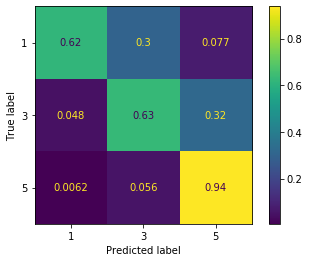

In [107]:
predictions = mnb.predict(X_test)
score = mnb.score(X_test, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(mnb, X_test, y_test, normalize = "true")

# Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression

In [103]:
params = {
    'penalty': ['l2'],
    'C': [0.01, 0.1 , 1, 10],
    'max_iter': [1000000]
} 
logreg = LogisticRegression()
logreg_grid = GridSearchCV(logreg, params)
logreg_grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [1000000],
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [104]:
cv_results = pd.DataFrame(logreg_grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.308464,0.028530,0.002602,0.000491,0.01,1000000,l2,"{'C': 0.01, 'max_iter': 1000000, 'penalty': 'l2'}",0.826327,0.834165,0.830602,0.826831,0.838055,0.831196,0.004449,3
1,3.017821,0.132668,0.002400,0.000490,0.1,1000000,l2,"{'C': 0.1, 'max_iter': 1000000, 'penalty': 'l2'}",0.840933,0.846633,0.846455,0.848210,0.851595,0.846765,0.003451,1
2,6.258557,0.087722,0.002400,0.000489,1,1000000,l2,"{'C': 1, 'max_iter': 1000000, 'penalty': 'l2'}",0.830602,0.840221,0.836124,0.837342,0.844468,0.837751,0.004586,2
3,10.778316,0.407257,0.002600,0.000490,10,1000000,l2,"{'C': 10, 'max_iter': 1000000, 'penalty': 'l2'}",0.816352,0.821696,0.818133,0.822020,0.828078,0.821256,0.004028,4


In [105]:
cv_results.loc[cv_results.rank_test_score == 1].params

1    {'C': 0.1, 'max_iter': 1000000, 'penalty': 'l2'}
Name: params, dtype: object

Lets train the mnb classifier using all the data and these hyperparameters...

In [108]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

multinominal naive bayes accuracy: 0.8463


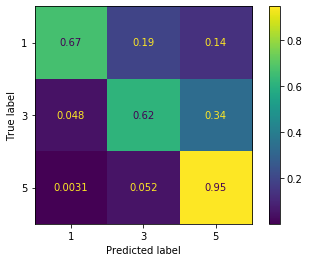

In [110]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(logreg, X_test, y_test, normalize = "true")

Since the class labels are imbalanced, lets try undersampling/oversampling the training data...

In [56]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [57]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_resampled, y_resampled)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

multinominal naive bayes accuracy: 0.7893


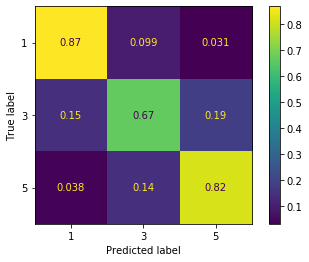

In [58]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(logreg, X_test, y_test, normalize = "true")

Undersampling/Oversampling doesn't seem to work... Reducing number of training instances is hurting accuracy...

# SVM Linear Kernel

In [38]:
from sklearn.svm import SVC

In general, SVM is O(n^3). Therefore, it is use feature selection... Going to use filter method 'SelectKBest'.

In [39]:
KBest = SelectKBest(chi2, k = 500)
KBest.fit(X_train, y_train)
X_train_best = KBest.transform(X_train)
X_test_best = KBest.transform(X_test)

svm grid search too expensive...

In [40]:
svc = SVC(kernel = 'linear', C = 1)
svc.fit(X_train_best, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

multinominal naive bayes accuracy: 0.8331


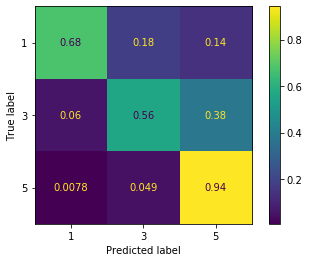

In [41]:
score = svc.score(X_test_best, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(svc, X_test_best, y_test, normalize = "true")

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
X_best = KBest.transform(X)

with feature selection...

In [50]:
rfc_KBest = RandomForestClassifier()
cross_val_score(rfc, X_best, y)

array([0.79034556, 0.79283933, 0.79693623, 0.79618742, 0.80010689])

without feature selection...

In [49]:
rfc = RandomForestClassifier()
cross_val_score(rfc, X, y)

array([0.75721411, 0.7605985 , 0.75685786, 0.75378585, 0.75610191])

In [51]:
rfc_KBest = RandomForestClassifier()
rfc_KBest.fit(X_train_best, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

random forest classifier accuracy: 0.7944


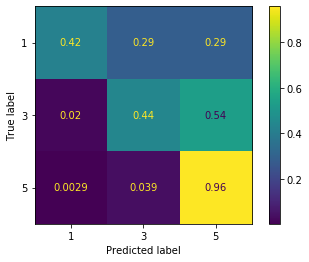

In [52]:
score = rfc_KBest.score(X_test_best, y_test)
print("random forest classifier accuracy: {:.4f}".format(score))
plot_confusion_matrix(rfc_KBest, X_test_best, y_test, normalize = "true")

# Adaboost Classifier

In [61]:
from sklearn.ensemble import AdaBoostClassifier

In [64]:
ada = AdaBoostClassifier()
cross_val_score(ada, X, y)

array([0.78001425, 0.78892056, 0.79301746, 0.78300374, 0.78834848])

In [66]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

multinominal naive bayes accuracy: 0.7866


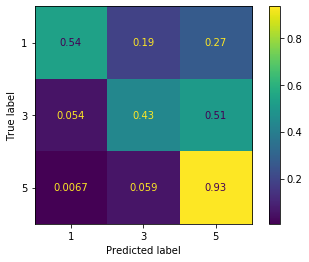

In [67]:
predictions = ada.predict(X_test)
score = ada.score(X_test, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(ada, X_test, y_test, normalize = "true")

In [69]:
ada = AdaBoostClassifier()
ada.fit(X_train_best, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

doest do any better with feature selection...

multinominal naive bayes accuracy: 0.7879


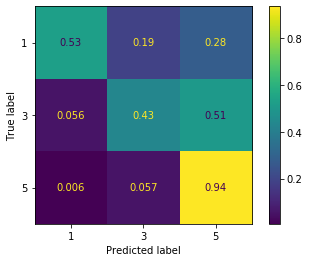

In [70]:
score = ada.score(X_test_best, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(ada, X_test_best, y_test, normalize = "true")

Logistic Regression seems to be the best individual classifier. Lets trying tinkering around with some Logistic Regression parameters before we trying stacking the learners.

# Logistic Regression 2

Lets train the mnb classifier using all the data and these hyperparameters...

In [80]:
for ngrams in range(1, 4):
    
    X = train_data.review
    y = train_data.rating

    vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, ngrams))
    vectorizer.fit(X)
    X = vectorizer.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    
    logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
    logreg.fit(X_train, y_train)
    score = logreg.score(X_test, y_test)
    
    print("ngrams = {}, logistic regression score is {}".format(ngrams, score))

ngrams = 1, logistic regression score is 0.8462771642322765
ngrams = 2, logistic regression score is 0.8537584609903812
ngrams = 3, logistic regression score is 0.8491271820448878


Lets try with feature selection using ngrams = 2...

In [81]:
X = train_data.review
y = train_data.rating

vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, 2))
vectorizer.fit(X)
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

KBest = SelectKBest(chi2, k = 500)
KBest.fit(X_train, y_train)
X_train_best = KBest.transform(X_train)
X_test_best = KBest.transform(X_test)

logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_train_best, y_train)
score = logreg.score(X_test_best, y_test)

print(score)

0.8370146063412897


In [180]:
X = train_data.review
y = train_data.rating

other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']
features = train_data[other_features]

In [181]:
vectorizer = CountVectorizer(ngram_range = (1, 2))
vectorizer.fit(X)
X = vectorizer.transform(X)

# stack the other features
from scipy import sparse
X = sparse.hstack((X, np.array(features)))

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [183]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_train, y_train)
score = logreg.score(X_test, y_test)

In [186]:
print(score)

0.8799429996437478


# CROSS VALIDATION FOR ALL MODELS

In [417]:
from sklearn.utils import shuffle
import time

X = train_data[['review', 'total_votes', 'vote_funny', 'vote_cool', 'vote_useful']]
y = train_data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

X_train_clfs, X_train_meta, y_train_clfs, y_train_meta = train_test_split(X_train, y_train, train_size = 0.8, random_state = 0)

classifiers = {
    "mnb": MultinomialNB(alpha = 1),
    "rfc": RandomForestClassifier(),
    "lr": LogisticRegression(max_iter=1000000, C = 0.1, penalty = 'l2'),
    "svm":  SVC(kernel = 'linear', C = 1.0),
    "adaboost": AdaBoostClassifier()
}

clfs = []

vectorizer = CountVectorizer(ngram_range = (1, 2))
vectorizer.fit(X_train_clfs.review)

X_train_clfs_review = vectorizer.transform(X_train_clfs.review)
other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']
X_train_clfs = sparse.hstack((X_train_clfs_review, np.array(X_train_clfs[other_features])))

In [419]:
for classifier in list(classifiers.keys()):
    
    print("training {}".format(classifier))
    
    clf = classifiers[classifier]
    
    clf.fit(X_train_clfs, y_train_clfs)
    
    clfs.append(clf)

training mnb
training rfc
training lr
training svm
training adaboost


In [433]:
predictions_dict = {}

for clf in clfs:
    
        X_test_review = vectorizer.transform(X_test.review)
        other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']
        X_test_sparse = sparse.hstack((X_test_review, np.array(X_test[other_features])))
        predictions = clf.predict(X_test_sparse)
        predictions_dict[clf.__class__] = predictions

In [434]:
predictions_dict

{sklearn.naive_bayes.MultinomialNB: array([5, 5, 5, ..., 5, 5, 5], dtype=int64),
 sklearn.ensemble._forest.RandomForestClassifier: array([5, 5, 5, ..., 5, 5, 5], dtype=int64),
 sklearn.linear_model._logistic.LogisticRegression: array([5, 5, 3, ..., 5, 5, 5], dtype=int64),
 sklearn.svm._classes.SVC: array([5, 5, 3, ..., 5, 5, 5], dtype=int64),
 sklearn.ensemble._weight_boosting.AdaBoostClassifier: array([5, 5, 5, ..., 5, 5, 5], dtype=int64)}

In [438]:
keys = list(predictions_dict.keys())

In [439]:
combos = list(combinations(keys, 3))

In [441]:
combos = list(combinations(keys, 3))
for combo in combos:
    pred1 = predictions_dict[combo[0]]
    pred2 = predictions_dict[combo[1]]
    pred3 = predictions_dict[combo[2]]
    predictions_df = pd.DataFrame(np.stack((pred1, pred2, pred3)).transpose())
    predictions_df = predictions_df.rename(columns = {0: "pred1", 1: "pred2", 2: "pred3"})
    predictions_df['mode'] = predictions_df.apply(lambda x: Counter([x["pred1"], x["pred2"], x["pred3"]]).most_common(1)[0][0], axis = 1)
    score = accuracy_score(predictions_df['mode'], y_test)
    print('''{}:
    {}'''.format(combo, score))

(<class 'sklearn.naive_bayes.MultinomialNB'>, <class 'sklearn.ensemble._forest.RandomForestClassifier'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>):
    0.7604203776273601
(<class 'sklearn.naive_bayes.MultinomialNB'>, <class 'sklearn.ensemble._forest.RandomForestClassifier'>, <class 'sklearn.svm._classes.SVC'>):
    0.7589953687210546
(<class 'sklearn.naive_bayes.MultinomialNB'>, <class 'sklearn.ensemble._forest.RandomForestClassifier'>, <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>):
    0.7470609191307446
(<class 'sklearn.naive_bayes.MultinomialNB'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.svm._classes.SVC'>):
    0.8664054150338439
(<class 'sklearn.naive_bayes.MultinomialNB'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>):
    0.8302458140363377
(<class 'sklearn.naive_bayes.MultinomialNB'>, <class 'sklearn.svm._classes.SVC'>, <class '

In [442]:
accuracy_score(list(predictions_dict.values())[3], y_test)

0.8574991093694335

In [443]:
pred1 = predictions_dict[combo[0]]
pred2 = predictions_dict[combo[1]]
pred3 = predictions_dict[combo[2]]

In [444]:
predictions_df = pd.DataFrame(np.stack((pred1, pred2, pred3)).transpose())
predictions_df = predictions_df.rename(columns = {0: "pred1", 1: "pred2", 2: "pred3"})
predictions_df['mode'] = predictions_df.apply(lambda x: Counter([x["pred1"], x["pred2"], x["pred3"]]).most_common(1)[0][0], axis = 1)
accuracy_score(predictions_df['mode'], y_test)

0.8697898111863199

In [242]:
classifiers = {
    "mnb": MultinomialNB(alpha = 1),
    "rfc": RandomForestClassifier(),
    "lr": LogisticRegression(max_iter=1000000, C = 0.1, penalty = 'l2'),
    "svm":  SVC(kernel = 'linear', C = 1.0),
    "adaboost": AdaBoostClassifier()
}

In [250]:
X_test

array([[5, 5, 5, ..., 2, 2, 3],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 3, ..., 3, 2, 3],
       ...,
       [5, 5, 5, ..., 0, 0, 1],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=int64)

In [290]:
X_train_meta.shape

(4491, 9)

In [283]:
for meta_classifier in list(classifiers.keys()):
    
    print(meta_classifier)
    
    meta_clf = classifiers[meta_classifier]
    meta_clf.fit(X_train_meta, y_train_meta)
    
    X_test_review = vectorizer.transform(X_test.review)
    
    predictions_list = []
    
    for clf in clfs:

        predictions = clf.predict(X_test_review)
        predictions_list.append(predictions)
        
    clf_predictions = np.stack(predictions_list).transpose()
    X_test_meta = np.column_stack((clf_predictions, np.array(X_test[['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']])))
        
    meta_score = meta_clf.score(X_test_meta, np.array(y_test))
    
    print("classifier {} score is {}".format(meta_classifier, meta_score))

mnb
classifier mnb score is 0.6626291414321339
rfc
classifier rfc score is 0.8656929105806911
lr
classifier lr score is 0.871571072319202
svm
classifier svm score is 0.8726398289989312
adaboost
classifier adaboost score is 0.8729960812255076


In [ ]:
for meta_classifier in list(classifiers.keys()):
    
    print(meta_classifier)
    
    meta_clf = classifiers[meta_classifier]
    meta_clf.fit(X_train_meta, y_train_meta)
    
    X_test_review = vectorizer.transform(X_test.review)
    
    predictions_list = []
    
    for clf in clfs:

        predictions = clf.predict(X_test_review)
        predictions_list.append(predictions)
        
    clf_predictions = np.stack(predictions_list).transpose()
    X_test_meta = np.column_stack((clf_predictions, np.array(X_test[['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']])))
        
    meta_score = meta_clf.score(X_test_meta, np.array(y_test))
    
    print("classifier {} score is {}".format(meta_classifier, meta_score))

In [286]:
clf.__class__

sklearn.ensemble._weight_boosting.AdaBoostClassifier

In [287]:
predictions_list = {}
    
for clf in clfs:

    predictions = clf.predict(X_test_review)
    predictions_list[clf.__class__] = predictions

In [288]:
predictions_list

{sklearn.naive_bayes.MultinomialNB: array([5, 5, 5, ..., 5, 5, 5], dtype=int64),
 sklearn.ensemble._forest.RandomForestClassifier: array([5, 5, 5, ..., 5, 5, 5], dtype=int64),
 sklearn.linear_model._logistic.LogisticRegression: array([5, 5, 3, ..., 5, 5, 5], dtype=int64),
 sklearn.svm._classes.SVC: array([5, 5, 3, ..., 5, 5, 5], dtype=int64),
 sklearn.ensemble._weight_boosting.AdaBoostClassifier: array([5, 5, 5, ..., 5, 5, 5], dtype=int64)}

In [235]:
logreg.fit(X_train_meta, y_train_meta)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [236]:
logreg.score(X_train_meta, y_train_meta)

0.9067022934758405

In [238]:
predictions_list = []

X_test_review = vectorizer.transform(X_test.review)

for clf in clfs:
    
        predictions = clf.predict(X_test_review)
        predictions_list.append(predictions)
        
predictions = np.stack(predictions_list).transpose()

In [239]:
X_test = np.column_stack((predictions, np.array(X_test[['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']])))

In [241]:
logreg.score(X_test, y_test)

0.8662272889205558

In [ ]:
# X_train_meta = sparse.hstack((X_train_meta_review, np.array(X_train_meta[['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']])))


In [95]:
train = shuffle(train_data[['rating', 'review']], random_state = 0)
folds = np.array_split(train, 5)

In [193]:
X = train_data[['review', 'total_votes', 'vote_funny', 'vote_cool', 'vote_useful']]
y = train_data['rating']

In [ ]:
X = train_data[['review', 'total_votes', 'vote_funny', 'vote_cool', 'vote_useful']]
y = train_data['rating']



meta_X

for classifier in list(classifiers.keys()):
    
    clf = classifiers[classifier]
    
    test_scores = []
    
    for fold_n in range(5):
        
        
        train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
        train_fold = pd.concat(train_folds, axis = 0)
        
        test_fold = folds[fold_n]

        X_train_txt, y_train = train_fold["review"], np.array(train_fold["rating"])
        X_test_txt, y_test = test_fold["review"], np.array(test_fold["rating"])
        
        vectorser = CountVectorizer(ngram_range=(1, 1))
        vectoriser.fit(X_train_txt)
        X_train = vectoriser.transform(X_train_txt)
        X_test = vectoriser.transform(X_test_txt)
        
        # If its the RFC, optimise it by feature selecting
        if(classifier == "RFC"):
            x2 = SelectKBest(chi2, k=1000)
            X_train = x2.fit_transform(X_train, y_train)
            X_test = x2.transform(X_test)

        before = time.time()
        clf.fit(X_train, y_train)
        after = time.time()
        train_time = after - before

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        test_scores.append(test_score)
        
        print(
            '''
            {} took {:.2f} seconds to train
            and has training accuracy {:.3f} and testing accuracy {:.3f}
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            '''.format(classifier, train_time, train_score, test_score)
        )
    
    mean_test_score = np.mean(test_scores)
    
    print("the mean test score for {} was {:.3f}".format(classifier, mean_test_score))

TESTING ON COUNTVECTORIZER

            RFC took 36.19 seconds to train
            and has training accuracy 0.987 and testing accuracy 0.786
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            RFC took 36.41 seconds to train
            and has training accuracy 0.987 and testing accuracy 0.784
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            RFC took 36.90 seconds to train
            and has training accuracy 0.987 and testing accuracy 0.786
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            RFC took 36.54 seconds to train
            and has training accuracy 0.987 and testing accuracy 0.781
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            RFC took 37.18 seconds to train
            and has training accuracy 0.987 and testing accuracy 0.780
            - - - - - - - - - - -

C:\Users\alecy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            LR took 4.41 seconds to train
            and has training accuracy 0.950 and testing accuracy 0.862
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\Users\alecy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            LR took 4.43 seconds to train
            and has training accuracy 0.948 and testing accuracy 0.858
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\Users\alecy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            LR took 4.01 seconds to train
            and has training accuracy 0.950 and testing accuracy 0.857
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\Users\alecy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            LR took 4.46 seconds to train
            and has training accuracy 0.950 and testing accuracy 0.855
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\Users\alecy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            LR took 4.94 seconds to train
            and has training accuracy 0.954 and testing accuracy 0.859
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            
the mean test score for LR was 0.858

            SVMLINEAR took 618.65 seconds to train
            and has training accuracy 0.995 and testing accuracy 0.842
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            SVMLINEAR took 600.04 seconds to train
            and has training accuracy 0.994 and testing accuracy 0.839
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


# Stacking
seems like the doc2vec vectors aren't as informative as the countVectoriser  
best to use ngrams(1,1) for doc2vecs? (1,2) causes marginal difference in other models, but causes around a 10% accuracy dip for multinomial  
RFC gains around 7-8% accuracy if trained using chi2 features  
of course, chi2 can't be used for d2v inputs as they contain negative values  
MNB also can't be used for d2v inputs

All except MNB:  
first do for d2v_50_train  84~  
stacking ~ 85% for 50  
86.2% for 200

In [85]:
vectoriser = CountVectorizer(ngram_range=(1, 2))

scores = []

classifiers = {
    #"MNB": MultinomialNB(),
    "RFC": RandomForestClassifier(max_depth = 50),
    "ADA": AdaBoostClassifier(),
    "XGB": XGBClassifier(),
    "LR": LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, C = 0.1),
    "SVMLINEAR":  SVC(kernel='linear', C=1.0)
}

# Include the meta features with the doc2vec
dataframe = pd.concat([d2v_200_train.reset_index(), train_meta.reset_index()], axis = 1)
# Above concat method causes duplicating index column
dataframe = dataframe.loc[:,~dataframe.columns.duplicated()]
dataframe = dataframe.drop(columns = ['index'])
    
train = shuffle(dataframe, random_state = 0)
folds = np.array_split(train, 5)


# loop

for fold_n in range(5):
    
    print(fold_n)
    
    train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
    train_fold = pd.concat(train_folds, axis = 0)
    test_fold = folds[fold_n]
    
    meta_train, meta_test = train_test_split(dataframe)
    
    # split and train the model. Include all columns other than rating in training
    X_train, y_train = train_fold[train_fold.columns.difference(["rating"])], np.array(train_fold["rating"])
    X_test, y_test = test_fold[train_fold.columns.difference(["rating"])], np.array(test_fold["rating"])

    before = time.time()
    clfs = []
    predictions_list = []
    
    for classifier in list(classifiers.keys()):

        clf = classifiers[classifier]
        clfs.append(clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print("{} accuracy {}".format(classifier, score))
        predictions = clf.predict(X_test)
        predictions_list.append(predictions)

    after = time.time()
    print("TIME: ", after - before)
    meta_clf = RandomForestClassifier()
    meta_clf.fit(np.stack(predictions_list).transpose(), y_test)

    # lets test the meta classifier on the meta test data

    reviews = meta_test
    new_predictions = []
    
    # Predict the test set without rating column
    for clf in clfs:
        predictions = clf.predict(meta_test[meta_test.columns.difference(["rating"])])
        new_predictions.append(predictions)

    score = meta_clf.score(np.stack(new_predictions).transpose(), meta_test.rating)
    scores.append(score)
    print("stacking accuracy is {}".format(score))

0
RFC accuracy 0.7278232988956181
ADA accuracy 0.7502671891699323
XGB accuracy 0.8120769504809405
LR accuracy 0.8350552190951194
SVMLINEAR accuracy 0.8339864624153901
TIME:  706.2092406749725
stacking accuracy is 0.8626193529998575
1


KeyboardInterrupt: 

In [15]:
np.mean(scores)

0.8459455607809605

now try for splitVectorised()
same as mike, but small changes to parameters in model. also trains random forest classifier differently to others (feature selection)   
Using meta_clf = Logit:  
all except mnb give 86.5  
all except svm give 86.7, with lemmatokenizer and stop words 85%   
all except mnb and svm gives 86.6    
all except rfc = 86.5  
using metaclf = XBG:  
all except svm sometimes 77 most times 87.2  

In [36]:
from sklearn.dummy import DummyClassifier

In [90]:
vectoriser = CountVectorizer(ngram_range=(1, 2))

scores = []

classifiers = {
    "MNB": MultinomialNB(),
    "RFC": RandomForestClassifier(max_depth = 50),
    "ADA": AdaBoostClassifier(),
    "XGB": XGBClassifier(),
    "LR": LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, C = 0.1),
    "SVMLINEAR":  SVC(kernel='linear', C=0.1)
}

# loop

train = shuffle(train_data[['rating', 'review']], random_state = 0)
folds = np.array_split(train, 5)

for fold_n in range(5):
    
    print(fold_n)
    
    meta_train, meta_test = train_test_split(train_data[['rating', 'review']])
    train = shuffle(meta_train)
    
    folds = np.array_split(train, 5)

    train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
    train_fold = pd.concat(train_folds, axis = 0)
    test_fold = folds[fold_n]

    X_train_txt, y_train = train_fold["review"], np.array(train_fold["rating"])
    X_test_txt, y_test = test_fold["review"], np.array(test_fold["rating"])

    vectoriser.fit(X_train_txt)
    X_train = vectoriser.transform(X_train_txt)
    X_test = vectoriser.transform(X_test_txt)

    before = time.time()
    
    clfs = []
    
    predictions_list = []
    
    for classifier in list(classifiers.keys()):

        clf = classifiers[classifier]
        clfs.append(clf)
        
        # could so some feature selection here potentially, or train separate models differently
        if("RFC" in classifiers and classifier == "RFC"):
            # Optimise RFC with feature selection. Train the model using these k features
            x2 = SelectKBest(chi2, k=1000)
            X_train_rfc = x2.fit_transform(X_train, y_train)
            X_test_rfc = x2.transform(X_test)
            
            clf.fit(X_train_rfc, y_train)
            
            score = clf.score(X_test_rfc, y_test)
            print("{} accuracy {}".format(classifier, score))
            
            predictions = clf.predict(X_test_rfc)
            
        else:
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            print("{} accuracy {}".format(classifier, score))
            predictions = clf.predict(X_test)
            
        predictions_list.append(predictions)

    after = time.time()
    print("TIME", after - before)
    
    #meta_clf = RandomForestClassifier()
    #meta_clf = DummyClassifier(strategy="most_frequent")
    #meta_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, C = 0.1)
    #meta_clf = SVC(kernel='linear', C=1.0)
    meta_clf = XGBClassifier()
    
    meta_clf.fit(np.stack(predictions_list).transpose(), y_test)

    # lets test the meta classifier on the meta test data

    reviews = vectoriser.transform(meta_test.review)
    new_predictions = []
    
    for clf in clfs:
        if("RFC" in classifiers and clf == classifiers["RFC"]):
            # Select best k features in meta_test
            x2 = SelectKBest(chi2, k=1000)
            reviews_rfc = x2.fit_transform(reviews, meta_test.rating)
            predictions = clf.predict(reviews_rfc)
        else:
            predictions = clf.predict(reviews)
            
        new_predictions.append(predictions)

    score = meta_clf.score(np.stack(new_predictions).transpose(), meta_test.rating)
    scores.append(score)
    print("stacking accuracy is {}".format(score))

0
MNB accuracy 0.7537402042270245
RFC accuracy 0.7964853953930183
ADA accuracy 0.7891237235810972
XGB accuracy 0.8537164568985989
LR accuracy 0.8727143196390406
SVMLINEAR accuracy 0.865590121111375
TIME 788.207319021225
stacking accuracy is 0.8540686903235001
1


KeyboardInterrupt: 

# try some kaggle

In [68]:
# Just normal Logistic regression model
# using count vectoriser
print('\033[1m' + f"Trained with vectorised features" '\033[0m')
X_train, X_vali, Y_train, Y_vali, vectoriser = splitVectorised((1,2))
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train, Y_train)
Y_pred = clf.predict(X_vali)
evaluate(Y_pred, Y_vali)

Trained with vectorised features
The accuracy of the predictions is: 0.87068

Confusion Matrix of Correctly Labeled Classes %'s

Predicted         1         3         5
Truths                                 
1          0.669528  0.053613  0.003885
3          0.193133  0.692308  0.041699
5          0.137339  0.254079  0.954416





In [69]:
X_test = vectoriser.transform(test_text.review)
Y_pred = clf.predict(X_test)
Y_pred

array([5, 5, 1, ..., 3, 5, 5], dtype=int64)

In [73]:
predictionsdf = pd.DataFrame(list(enumerate(Y_pred, start = 1)))
predictionsdf = predictionsdf.rename(columns = {0: 'instance_id', 1: 'rating'})
predictionsdf.to_csv("preds1.csv", index = False)
predictionsdf

,instance_id,rating
0,1,5
1,2,5
2,3,1
3,4,3
4,5,5
5,6,5
6,7,5
7,8,5
8,9,5
9,10,5


In [80]:
# Try the stacking model now

vectoriser = CountVectorizer(ngram_range=(1, 2))

scores = []

classifiers = {
    #"MNB": MultinomialNB(),
    #"RFC": RandomForestClassifier(max_depth = 50),
    #"ADA": AdaBoostClassifier(),
    #"XGB": XGBClassifier(),
    "LR": LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, C = 0.1)
    #"SVMLINEAR":  SVC(kernel='linear', C=1.0)
}

# loop


meta_train, meta_test = train_test_split(train_data[['rating', 'review']])
train = shuffle(meta_train)
    
vectoriser.fit(X_train_txt)
X_train = vectoriser.transform(meta_train.review)
Y_train = meta_train.rating

X_test = vectoriser.transform(meta_test.review)
y_test = meta_test.rating
    
clfs = []

predictions_list = []
    
for classifier in list(classifiers.keys()):

    clf = classifiers[classifier]
    clfs.append(clf)
        
    # could so some feature selection here potentially, or train separate models differently
    if("RFC" in classifiers and classifier == "RFC"):
        # Optimise RFC with feature selection. Train the model using these k features
        x2 = SelectKBest(chi2, k=1000)
        X_train_rfc = x2.fit_transform(X_train, y_train)
        X_test_rfc = x2.transform(X_test)
            
        clf.fit(X_train_rfc, Y_train)
            
        score = clf.score(X_test_rfc, y_test)
        print("{} accuracy {}".format(classifier, score))
            
        predictions = clf.predict(X_test_rfc)
            
    else:
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, y_test)
        print("{} accuracy {}".format(classifier, score))
        predictions = clf.predict(X_test)
            
    predictions_list.append(predictions)

#meta_clf = RandomForestClassifier()
#meta_clf = DummyClassifier(strategy="most_frequent")
meta_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, C = 0.1)
#meta_cld = SVC(kernel='linear', C=1.0)
    
meta_clf.fit(np.stack(predictions_list).transpose(), y_test)


LR accuracy 0.8818583440216616


LogisticRegression(C=0.1, max_iter=1000, multi_class='multinomial')

In [82]:
X_test = vectoriser.transform(test_text.review)

predictions_list = []

for classifier in list(classifiers.keys()):

    clf = classifiers[classifier]

    predictions = clf.predict(X_test)

    predictions_list.append(predictions)
    
predictions = meta_clf.predict(np.stack(predictions_list).transpose())

predictions



array([5, 5, 1, ..., 5, 5, 5], dtype=int64)

# Predictions

In [173]:
X = train_data.review
y = train_data.rating

other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']
features = train_data[other_features]

In [174]:
vectorizer = CountVectorizer(ngram_range = (1, 2))
vectorizer.fit(X)
X = vectorizer.transform(X)

# stack the other features
from scipy import sparse
X = sparse.hstack((X, np.array(features)))

In [175]:
KBest = SelectKBest(chi2, k = 1000)
KBest.fit(X, y)
X_train_best = KBest.transform(X)

In [176]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_train_best, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [177]:
X_predict = test_data.review
X_predict = vectorizer.transform(X_predict)

test_data['total_votes'] = test_data['vote_funny'] + test_data['vote_cool'] + test_data['vote_useful']
features = test_data[other_features]
X_predict = sparse.hstack((X_predict, np.array(features)))

X_predict = KBest.transform(X_predict)

predictions = logreg.predict(X_predict)

In [178]:
predictions

array([5, 5, 1, ..., 3, 5, 5], dtype=int64)

In [179]:
predictionsdf = pd.DataFrame(list(enumerate(predictions, start = 1)))
predictionsdf = predictionsdf.rename(columns = {0: 'instance_id', 1: 'rating'})
predictionsdf.to_csv("logistic_regression.csv", index = False)
predictionsdf

,instance_id,rating
0,1,5
1,2,5
2,3,1
3,4,3
4,5,5
...,...,...
7013,7014,5
7014,7015,5
7015,7016,3
7016,7017,5
